# A Fontastic Voyage: Generative Fonts with Adversarial Networks

Two weeks ago there was a lot of buzz around Erik Bernhardsson's [blog post](http://erikbern.com/2016/01/21/analyzing-50k-fonts-using-deep-neural-networks/), where he trained an autoencoder on more than 50,000 fonts. The results are fantastic and if you haven't seen it yet, go check [it out](http://erikbern.com/2016/01/21/analyzing-50k-fonts-using-deep-neural-networks/). A few months back we released a package called [fauxtograph](https://github.com/stitchfix/fauxtograph), which performs unsupervised deep learning on images via variational autoencoding ([VAE](http://arxiv.org/abs/1312.6114)). Less than a week ago we implemented some big changes in fauxtograph where convolutional and adversarial network ([GAN](http://arxiv.org/abs/1511.06434)) capabilities were added. So how will the updates in the package do with the fonts dataset that Erik shared?

We will train both VAE and GAN models on fonts and then explore the font-space by printing out arbitrary strings in a font that interpolates between randomly generated fonts using our trained models. This post follows along a [Jupyter Notebook](https://github.com/stitchfix/Algorithms-Notebooks/blob/master/font_blog/a_fotastic_voyage.ipynb) that will take us through the necessary elements to achieve our end goal.

## Preliminaries/Dependencies

To follow along with the notebook make sure to do the following:
1. Downloaded the latest version of fauxtograph (see below).
2. Download the [font data](https://s3.amazonaws.com/erikbern/fonts.hdf5) via the script below or clicking the link.
3. **(optional)** If you have a CUDA-capable GPU and want to use its considerable computing capabilities, install the Chainer cuda dependencies (see below).
4. In order to read the font data we need to grab the `h5py` module. The code below should ensure you can run the rest of the notebook.
5. In order to help the GAN training converge quickly (for reasons I won't cover here) it helps to do a slight guassian filtering of the training data. Thus you'll need to install `scipy` to facilitate this (see below).


In [ ]:
# Installs fauxtograph, its dependencies, scipy, and h5py.
!pip install --upgrade fauxtograph; pip install h5py; pip install scipy


# Optionally uncomment the line below and run for GPU capabilities.
# !pip install chainer-cuda-deps

# Optionally uncomment the line below to use wget to download the font dataset
# !wget https://s3.amazonaws.com/erikbern/fonts.hdf5

Now we'll import the `VAE` and `GAN` model classes from fauxtograph as well as the dependencies to read the dataset and display images in the notebook. 

In [1]:
from fauxtograph import VAE, GAN
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import numpy as np
from PIL import Image
import sys
%matplotlib inline


# These are two functions to reduce clutter in the
# notebook that pertain to training a model and plotting
# text in generated fonts. To review this code just look in the
# nb_tools.py file. 
from nb_tools import train_vae, train_gan, interpolating_font, show_latent_2d


## Import and Inspect the Data

Next we'll read in and inspect our data to see what our data looks like. 

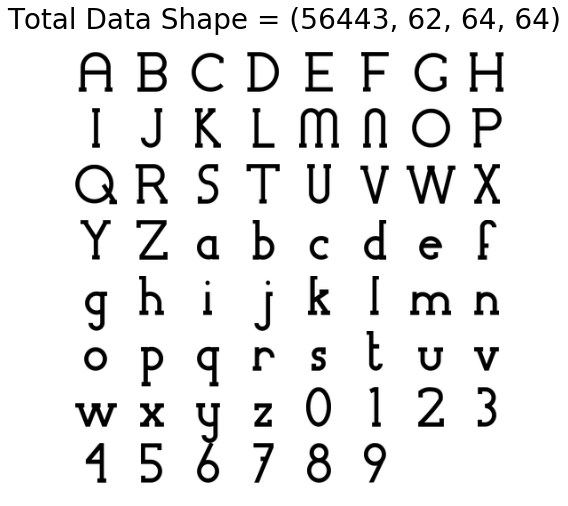

In [2]:
# Read our font data
fonts = h5py.File('/home/ubuntu/Data/fonts.hdf5','r')['fonts']

# Make a function to inspect what each font looks like.
def font_inspector(font_h5,font_number):
    # Make and 8x8 grid with no spacing between plots.
    fig = plt.figure(figsize=(8,8))
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0.0, hspace=0.0)
    
    # Put each font character into the grid.
    for i, letter in enumerate(255-font_h5[font_number]):
        plt.subplot(8,8,i+1)
        ax1 = plt.subplot(gs1[i])
        ax1.imshow(letter, 'gray')
        plt.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
    plt.suptitle("Total Data Shape = %s" % str(fonts.shape), fontsize=28)
    plt.savefig('font_image.png', transparent=False)
# Inspect a font.    
font_inspector(fonts, 0)


We see that there are 56,443 fonts where the individual characters are 64x64 grayscale images. Moreover, each font has an upper-case sequence, a lower-case sequence, and then the digits 0-9 for a total of 62 characters a piece. It would appear that punctuation marks, etc. are left out of this set, but these should be interesting enough.

## Training the Model

Now that we've had a chance to inspect the data we can use the `VAE` and `GAN` classes from fauxtograph that we imported earlier to train our generative model.

The following code instantiates the classes then trains them, outputting periodic updates in the form of randomly generated fonts for us to inspect as it trains. If you don't have a CUDA-capable gpu then just set the `flag_gpu` argument to `False`.

**Notice: This process takes some time to fully converge, but you should start to notice reasonable generated images in a few minutes on a GPU. If you'd like to skip this process, see the section below where we simply import a trained model.**

### A Sidenote on Training Methods (for those more familiar with ConvNets)

You'll note below that, for the VAE, we are training all 62 characters of the set as separate image channels. In practice this is a bad decision because it allows for cross talk in the network between different letter channels which should otherwise be treated separately. However, it allows us to use the VAE to generate arbitrary strings in generated fonts, which is cool enough to sacrifice some reconstruction performance for this post. If you are serious about modeling the font reconstructions though, you should be feeding the letters in one at a time (as is done when training the GAN below), ideally adding a one-hot encoding at the latent stage...or you could do something similar with an [adversarial autoencoder](http://arxiv.org/abs/1511.05644).

In [3]:
vae = VAE(img_width=64, img_height=64,
          color_channels=62, latent_width=60,
          kl_ratio=0.01, flag_gpu=True)

gan = GAN(img_width=64, img_height=64,
          color_channels=1, latent_width=2,
          flag_gpu=True)

In [ ]:
#Trains the VAE on all leters at once fed in thtrough separate channels.
train_vae(fonts, vae, save_path='./models/vae_model', save_freq=1)

In [ ]:
#Trains the gan on a specific font letter.
train_gan(fonts, gan, letter='A', save_path='./models/gan_model', save_freq=1)

## Adversarial Networks

While our models are training let's to go over the different unsupervised model types we will be using. The first class, VAE, stands for Variational Auto-encoder. If you are unfamiliar with these types of models then you might find it useful to read my [previous post](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/) or view my [talk](https://www.youtube.com/watch?v=-_4YbiJKmV8) on applying these models to images of clothing.

The second class, GAN, stands for Generative Adversarial Networks. In these types of models we pit two neural networks against one another. The first network is called a Generator. It takes a random system of numbers (a vector) and tries to use those numbers to generate an image. The other network is called a Discriminator. It processes both the randomly generated images from the Generator and training images from a dataset, then it tries to predict whether the processed images came from the Generator or the training set.

The Discriminator is then trained by reinforcing correct predictions, and the Generator is trained by reinforcing the connections which brought about images able to fool the discriminator. In other words, if the Generator tricks the Discriminator into thinking an generated image is from the training set, then that behavior is reinforced for the Generator and penalized for the Discriminator. On the other hand, if the Discriminator correctly identifies a fake image, then the opposite happens.

![gif](GAN.gif)

In this way the two networks compete against one another, and through iteration each makes the other better at its given task. Over time the Generator can become rather adept at producing reasonable looking images from the starting chosen vector, thus as with the VAE, we can use the generative portion of the model to generate new fonts.



## Importing a saved model

Whether you've chosen to train your own model or use one of the pre-trained ones here, we can load a trained model by with each class by calling the `load()` method. The method simply takes in the paths of the saved model files as well as the class metadata and then outputs the trained model instance. 

In [4]:

# Load your (pre)trained VAE model. Change these to your model paths
# if you want to use your own.
loader = {}
loader['model'] = './pretrained/vae_model_model.h5'
loader['opt'] = './pretrained/vae_model_opt.h5'
loader['meta'] = './pretrained/vae_model_meta.json'
loader['flag_gpu'] = True
vae1 = VAE.load(**loader)


# Load your (pre)trained GAN model. Change these to your model paths
# if you want to use your own.
loader = {}
loader['dec'] = './pretrained/gan_model_dec.h5'
loader['disc'] = './pretrained/gan_model_disc.h5'
loader['dec_opt'] = './pretrained/gan_model_dec_opt.h5'
loader['disc_opt'] = './pretrained/gan_model_disc_opt.h5'
loader['meta'] = './pretrained/gan_model_meta.json'
loader['flag_gpu'] = True
gan1 = GAN.load(**loader)

## Exploring the VAE Font Space

Now we can finally explore the font space by writing an arbitrary string, then rendering that string in random fonts generated from our model. The function below with interpolate over a distance of `stride=15` characters between random fonts encoded in our model.

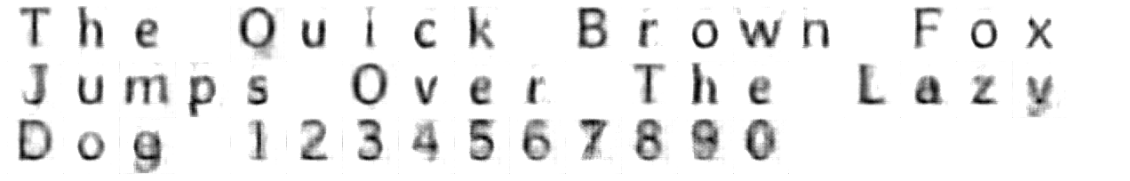

In [5]:
string = 'The Quick Brown Fox Jumps Over The Lazy Dog 1234567890'
interpolating_font(vae1, string, stride=15)

## Exploring the GAN Font Space

Since we have used our GAN to encode over a two dimensional space, we can actually visualize the encoding space as an image by using each discrete grid point in a cartesian grid as an input to our generator. Doing so we can see how the letter 'A' that we trained our model on above transforms by moving along each axis. 

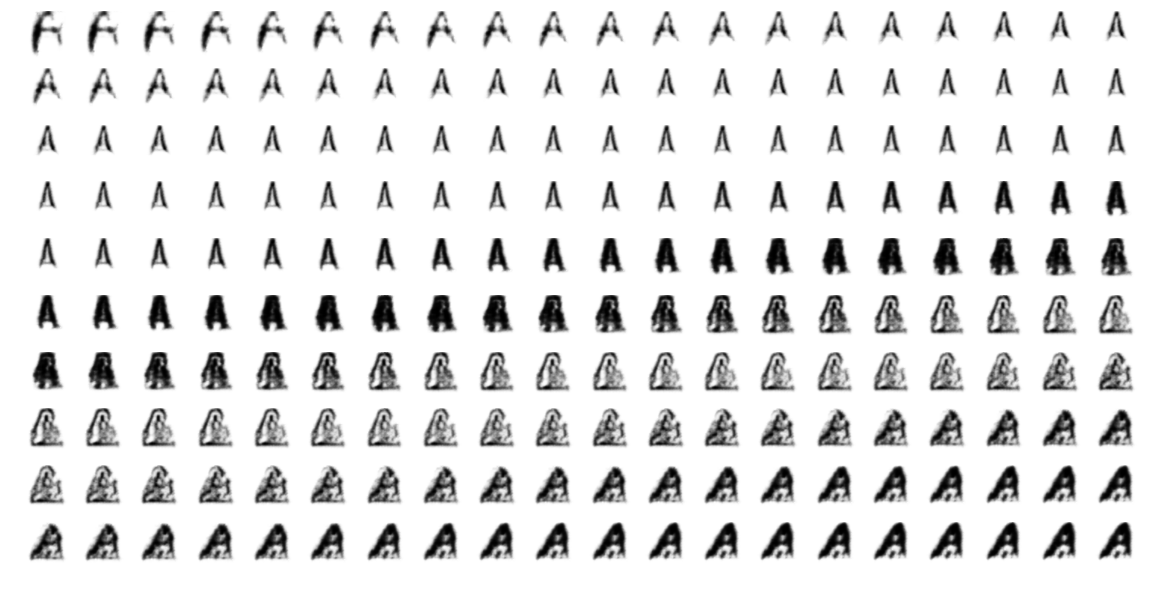

In [6]:
show_latent_2d(gan1)

## Conclusion

Hopefully you've gotten a sense over the course of this post how you might use some of the generative capabilities of both VAE and GAN models. The aim of the fauxtograph package is to make work like this reasonably accessible to anyone with some knowledge of Python. Feel free to try out different datasets for yourself. You'll find more info and an additional example notebook, applying the [VAE/GAN hybrid](http://arxiv.org/abs/1512.09300) algorithm, in the fauxtograph [GitHub repo](https://github.com/stitchfix/fauxtograph).